<a href="https://colab.research.google.com/github/solankybasant/MLP-for-regression-and-classification/blob/main/Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Assignment 3

* Name:Basant Solanky
* Roll Number:12040430
* References Used to Complete the Assignment
    * a.

## Part A [Taxi Fare Prediction Using Neural Network]

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"basantsolanky","key":"8f76a92067ba34cdef14278d540d561d"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

 99% 1.55G/1.56G [00:06<00:00, 253MB/s]
100% 1.56G/1.56G [00:06<00:00, 257MB/s]


In [ ]:
!unzip new-york-city-taxi-fare-prediction

Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv("/content/train.csv", nrows = 1000000)
test = pd.read_csv("/content/test.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


#pipeline

In [ ]:
# remove NULL values and outliers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
Scaler=StandardScaler()
class remove_missing_values(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.drop(X[X.isnull().any(1)].index, axis = 0)
        return X

class remove_irrelevant_values(BaseEstimator, TransformerMixin):
    
    def __init__(self, isFareAmount = True,
                 isPassengerCount = True,
                 isLatitudes = True,
                 isLongitudes = True):
        self.isFareAmount = isFareAmount
        self.isPassengerCount = isPassengerCount
        self.isLatitudes = isLatitudes
        self.isLongitudes = isLongitudes

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        if self.isFareAmount and 'fare_amount' in list(X.columns):
            X = X.drop(X[X['fare_amount']<=0].index, axis=0)
            
        if self.isPassengerCount:
            X = X.drop(X[X['passenger_count']<=0].index, axis=0)
            X = X.drop(X[X['passenger_count']>=7].index, axis=0)
        
        if self.isLatitudes:
            X = X.drop(X[X['pickup_latitude']<-90].index, axis=0)
            X = X.drop(X[X['pickup_latitude']>90].index, axis=0)

            X = X.drop(X[X['dropoff_latitude']<-90].index, axis=0)
            X = X.drop(X[X['dropoff_latitude']>90].index, axis=0)
        
        if self.isLongitudes:
            X = X.drop(X[X['pickup_longitude']<-180].index, axis=0)
            X = X.drop(X[X['pickup_longitude']>180].index, axis=0)

            X = X.drop(X[X['dropoff_longitude']<-180].index, axis=0)
            X = X.drop(X[X['dropoff_longitude']>180].index, axis=0)
        
        return X

class remove_outside_bb(BaseEstimator, TransformerMixin):
    
    def __init__(self, bb = (-74.5, -72.8, 40.5, 41.8)):
        self.bb = bb
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.outlier_index = X.loc[(X['pickup_longitude'] < self.bb[0]) | (X['pickup_longitude'] > self.bb[1]) | \
           (X['pickup_latitude'] < self.bb[2]) | (X['pickup_latitude'] > self.bb[3]) | \
           (X['dropoff_longitude'] < self.bb[0]) | (X['dropoff_longitude'] > self.bb[1]) | \
           (X['dropoff_latitude'] < self.bb[2]) | (X['dropoff_latitude'] > self.bb[3])].index
        X = X.drop(self.outlier_index, axis=0)
        return X
class fix_datetime_data_types(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols = ['pickup_datetime', 'key']):
        self.cols = cols

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in self.cols:
            X[col] = pd.to_datetime(X[col])
        return X


class remove_outliers(BaseEstimator, TransformerMixin):
    # Taking which column to modify as "col" parameter
    def __init__(self):
        pass
    
    def haversine_distance(self,lat1, long1, lat2, long2,train):
        data = [train]
        for i in data:
            R = 6371  #radius of earth in kilometers
            phi1 = np.radians(i[lat1])
            phi2 = np.radians(i[lat2])
          
            delta_phi = np.radians(i[lat2]-i[lat1])
            delta_lambda = np.radians(i[long2]-i[long1])
          
            #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
            a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
          
            #c = 2 * atan2( √a, √(1−a) )
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
          
            #d = R*c
            d = (R * c) #in kilometers
            i['H_Distance'] = d
        return d

    def fit(self,traina, y=None):
        self.H_Distance=self.haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',train)
        return self
    
    # remove all NaN values 
    def transform(self,train):
        train['H_Distance']=self.H_Distance
        train['key'] = pd.to_datetime(train['key'])
        train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])
        train = train.drop(train[train.isnull().any(1)].index, axis = 0)
        train = train.drop(train[train['fare_amount']<=0].index, axis=0)
        train = train.drop(train.loc[train['passenger_count']>6 ].index, axis = 0)
        train = train.drop(train.loc[train['passenger_count']<=0 ].index, axis = 0)
        train = train.drop(((train[train['pickup_latitude']<39.5])).index, axis=0)
        train = train.drop(((train[train['pickup_latitude']>41.5])).index, axis=0)
        train = train.drop(((train[train['dropoff_latitude']<39.5])).index, axis=0)
        train = train.drop(((train[train['dropoff_latitude']>41.5])).index, axis=0)
        train= train.drop(((train[train['pickup_longitude']<-74.5])).index, axis=0)
        train = train.drop(((train[train['pickup_longitude']>-73])).index, axis=0)
        train = train.drop(((train[train['dropoff_longitude']<-74.5])).index, axis=0)
        train = train.drop(((train[train['dropoff_longitude']>-73])).index, axis=0)
        train = train.drop(train.loc[(train['H_Distance']==0) & (train['fare_amount']>2.5)].index, axis=0)
        train = train.drop(((train[train['H_Distance']>130])).index, axis=0)
        return train


class remove_add_col(BaseEstimator, TransformerMixin):
    def __init__(self, col1,col2,col3):
        self.col1 = col1
        self.col2 = col2
        self.col3 = col3
    def fit(self,X, y=None):
        # self.median = X[self.col].median()
        return self

    def transform(self,X):
        # add columns
        data = [X]
        for i in data:
            i['Year'] = i['pickup_datetime'].dt.year
            i['Month'] = i['pickup_datetime'].dt.month
            i['Date'] = i['pickup_datetime'].dt.day
            i['Day of Week'] = i['pickup_datetime'].dt.dayofweek
            i['Hour'] = i['pickup_datetime'].dt.hour
        # remove non-numerical columns
        X.drop([self.col1,self.col2,self.col3],axis=1,inplace=True)
        return X

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipeline_1 = Pipeline([
    ('remove missing values', remove_missing_values()),
    ('remove irrelevant values', remove_irrelevant_values()),
    ('remove outside NYC', remove_outside_bb()),
    ('fix datetime data types', fix_datetime_data_types()),
    ('fillna', remove_outliers())

])
pipeline_2= Pipeline([
    ('attribs_adder', remove_add_col('fare_amount', 'key', 'pickup_datetime')),
    ('Standard_scaling', StandardScaler())
])
train_scaled= pipeline_1.fit_transform(train)
labels=train_scaled['fare_amount']
train_scaled=pipeline_2.fit_transform(train_scaled)
train_scaled=pd.DataFrame(train_scaled)
train_scaled

,0,1,2,3,4,5,6,7,8,9,10
0,3.580347,-1.057476,3.732680,-1.245074,-0.524043,-0.613505,-1.467419,-0.077106,-0.076260,-1.558517,0.539043
1,-1.113011,-1.413349,-0.141250,0.968800,-0.524043,1.328233,-0.933541,-1.525632,-1.228760,-1.045502,0.385322
2,-0.202690,0.362003,-0.478218,-0.029517,0.245918,-0.519613,-0.399662,0.502305,0.269490,-0.019471,-2.074213
3,-0.322718,-0.637363,-0.487364,0.209569,-0.524043,-0.150666,0.134216,-0.656517,0.615240,1.006560,-1.459330
4,0.197485,0.601407,0.495118,1.024618,-0.524043,-0.360065,-0.933541,-0.946222,-0.767760,-1.045502,-0.998167
...,...,...,...,...,...,...,...,...,...,...,...
96507,0.747285,1.197751,0.281045,1.297201,2.555803,-0.462457,0.668095,0.792010,0.960991,-1.045502,-0.998167
96508,0.338966,1.706370,0.001992,1.111140,-0.524043,-0.440077,1.201974,-0.366811,-0.076260,-0.019471,-0.229562
96509,-0.586243,-0.978247,-0.498815,-0.849906,-0.524043,-0.772046,1.735852,-1.235927,0.384740,-0.019471,0.539043
96510,-0.227668,0.198456,-0.238254,0.494534,1.785842,-0.579914,-1.467419,1.081715,-0.652510,1.006560,1.461368


In [ ]:
import tensorflow
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense
# from keras.optimizers import adam
from keras.layers import Dropout
from keras.metrics import MeanAbsoluteError,MeanAbsolutePercentageError,MeanSquaredError

## Create a baseline Neural network with the following specifications.
2 hidden layers, each with 16 and 8 neurons respectively. Sigmoid activation, Batch Size=128 for Gradient Descent.

In [ ]:
model = Sequential()
model.add(Dense(16,input_dim=11, activation = 'sigmoid',))
model.add(Dense(8,activation='sigmoid'))
model.add(Dense(1,activation='linear'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                192       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_scaled,labels,test_size=0.2,random_state=42)

In [ ]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_data=(X_train,y_train),epochs=25,batch_size=128)

Epoch 1/25
754/754 [==============================] - 6s 4ms/step - loss: 7.8792 - mean_squared_error: 155.2775 - mean_absolute_error: 7.8792 - mean_absolute_percentage_error: 58.3722 - val_loss: 5.9365 - val_mean_squared_error: 120.8833 - val_mean_absolute_error: 5.9365 - val_mean_absolute_percentage_error: 39.9227
Epoch 2/25
754/754 [==============================] - 3s 4ms/step - loss: 5.4688 - mean_squared_error: 108.2496 - mean_absolute_error: 5.4688 - mean_absolute_percentage_error: 39.6730 - val_loss: 5.1307 - val_mean_squared_error: 100.2484 - val_mean_absolute_error: 5.1307 - val_mean_absolute_percentage_error: 38.9317
Epoch 3/25
754/754 [==============================] - 3s 4ms/step - loss: 4.5026 - mean_squared_error: 89.0140 - mean_absolute_error: 4.5026 - mean_absolute_percentage_error: 31.5487 - val_loss: 3.9048 - val_mean_squared_error: 79.3508 - val_mean_absolute_error: 3.9048 - val_mean_absolute_percentage_error: 24.8242
Epoch 4/25
754/754 [============================

In [ ]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])

In [ ]:
results=model.fit(train_scaled,labels,validation_data=(X_train,y_train),epochs=25,batch_size=128)

Epoch 1/25
754/754 [==============================] - 4s 5ms/step - loss: 1.9481 - mean_squared_error: 19.5120 - mean_absolute_error: 1.9481 - mean_absolute_percentage_error: 17.8815 - val_loss: 1.9489 - val_mean_squared_error: 19.5886 - val_mean_absolute_error: 1.9489 - val_mean_absolute_percentage_error: 18.0957
Epoch 2/25
754/754 [==============================] - 3s 4ms/step - loss: 1.9400 - mean_squared_error: 19.4195 - mean_absolute_error: 1.9400 - mean_absolute_percentage_error: 17.8077 - val_loss: 1.9416 - val_mean_squared_error: 19.5202 - val_mean_absolute_error: 1.9416 - val_mean_absolute_percentage_error: 17.9952
Epoch 3/25
754/754 [==============================] - 3s 4ms/step - loss: 1.9321 - mean_squared_error: 19.3604 - mean_absolute_error: 1.9321 - mean_absolute_percentage_error: 17.7301 - val_loss: 1.9342 - val_mean_squared_error: 19.3737 - val_mean_absolute_error: 1.9342 - val_mean_absolute_percentage_error: 18.0863
Epoch 4/25
754/754 [==============================] 

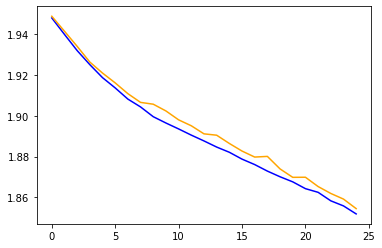

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

In [ ]:
y_pred=model.predict(train_scaled.iloc[:5])
y_pred

array([[ 7.4190893],
       [17.14906  ],
       [ 5.217228 ],
       [ 9.130789 ],
       [ 6.529293 ]], dtype=float32)

In [ ]:
labels.iloc[:5]

0     4.5
1    16.9
2     5.7
3     7.7
4     5.3
Name: fare_amount, dtype: float64

# Experiment with number of layers and neurons per layer to increase the performance metrics.

In [ ]:
# Increase number of layers 
model = Sequential()
model.add(Dense(16,input_dim=11, activation = 'sigmoid'))
model.add(Dense(8,activation='sigmoid'))
model.add(Dense(10,activation='sigmoid'))
model.add(Dense(1,activation='linear'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                192       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 10)                90        
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 429
Trainable params: 429
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_data=(X_train,y_train),epochs=25,batch_size=128)

Epoch 1/25
754/754 [==============================] - 4s 5ms/step - loss: 7.6505 - mean_squared_error: 150.4322 - mean_absolute_error: 7.6505 - mean_absolute_percentage_error: 57.6294 - val_loss: 5.5912 - val_mean_squared_error: 112.0781 - val_mean_absolute_error: 5.5912 - val_mean_absolute_percentage_error: 40.2752
Epoch 2/25
754/754 [==============================] - 3s 4ms/step - loss: 5.4012 - mean_squared_error: 104.0629 - mean_absolute_error: 5.4012 - mean_absolute_percentage_error: 42.2982 - val_loss: 5.3389 - val_mean_squared_error: 101.6448 - val_mean_absolute_error: 5.3389 - val_mean_absolute_percentage_error: 43.7551
Epoch 3/25
754/754 [==============================] - 3s 4ms/step - loss: 4.8706 - mean_squared_error: 94.0806 - mean_absolute_error: 4.8706 - mean_absolute_percentage_error: 37.1547 - val_loss: 4.1318 - val_mean_squared_error: 82.9740 - val_mean_absolute_error: 4.1318 - val_mean_absolute_percentage_error: 28.2754
Epoch 4/25
754/754 [============================

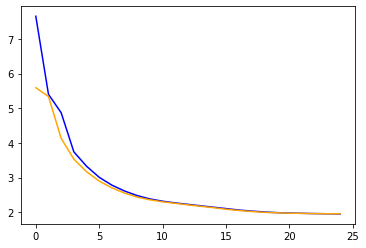

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

As we can see that there is not much affect<br> 
On increasing the layers realtion between loss and validation loss increases.

In [ ]:
# On decreasing number of layers
model = Sequential()
model.add(Dense(16,input_dim=11, activation = 'sigmoid'))
model.add(Dense(1,activation='linear'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 16)                192       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_data=(X_train,y_train),epochs=25,batch_size=128)

Epoch 1/25
754/754 [==============================] - 4s 4ms/step - loss: 7.5658 - mean_squared_error: 152.4998 - mean_absolute_error: 7.5658 - mean_absolute_percentage_error: 55.9178 - val_loss: 5.2197 - val_mean_squared_error: 104.5486 - val_mean_absolute_error: 5.2197 - val_mean_absolute_percentage_error: 36.8316
Epoch 2/25
754/754 [==============================] - 3s 4ms/step - loss: 4.3384 - mean_squared_error: 80.9180 - mean_absolute_error: 4.3384 - mean_absolute_percentage_error: 32.6169 - val_loss: 3.6531 - val_mean_squared_error: 64.6968 - val_mean_absolute_error: 3.6531 - val_mean_absolute_percentage_error: 28.1399
Epoch 3/25
754/754 [==============================] - 3s 4ms/step - loss: 3.2346 - mean_squared_error: 55.7809 - mean_absolute_error: 3.2346 - mean_absolute_percentage_error: 23.9153 - val_loss: 2.9947 - val_mean_squared_error: 50.3003 - val_mean_absolute_error: 2.9947 - val_mean_absolute_percentage_error: 21.8234
Epoch 4/25
754/754 [==============================

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

In [ ]:
# On increasing number of neurons per layers
model = Sequential()
model.add(Dense(20,input_dim=11, activation = 'sigmoid'))
model.add(Dense(10,activation='sigmoid'))
model.add(Dense(1,activation='linear'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_data=(X_train,y_train),epochs=25,batch_size=128)

Epoch 1/25
754/754 [==============================] - 4s 4ms/step - loss: 8.1568 - mean_squared_error: 160.1176 - mean_absolute_error: 8.1568 - mean_absolute_percentage_error: 61.1359 - val_loss: 6.0490 - val_mean_squared_error: 123.2781 - val_mean_absolute_error: 6.0490 - val_mean_absolute_percentage_error: 40.3704
Epoch 2/25
754/754 [==============================] - 3s 4ms/step - loss: 5.5394 - mean_squared_error: 110.1574 - mean_absolute_error: 5.5394 - mean_absolute_percentage_error: 39.6970 - val_loss: 5.2517 - val_mean_squared_error: 103.5467 - val_mean_absolute_error: 5.2517 - val_mean_absolute_percentage_error: 39.2338
Epoch 3/25
754/754 [==============================] - 3s 4ms/step - loss: 4.7315 - mean_squared_error: 94.1348 - mean_absolute_error: 4.7315 - mean_absolute_percentage_error: 32.8916 - val_loss: 4.1949 - val_mean_squared_error: 85.7179 - val_mean_absolute_error: 4.1949 - val_mean_absolute_percentage_error: 27.1007
Epoch 4/25
754/754 [============================

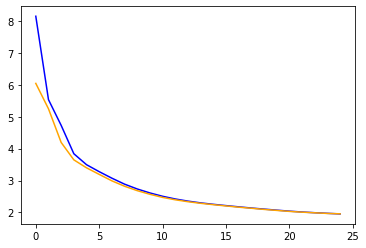

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

In [ ]:
# On decreasing number of neurons per layers
model = Sequential()
model.add(Dense(10,input_dim=11, activation = 'sigmoid'))
model.add(Dense(5,activation='sigmoid'))
model.add(Dense(1,activation='linear'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                120       
                                                                 
 dense_13 (Dense)            (None, 5)                 55        
                                                                 
 dense_14 (Dense)            (None, 1)                 6         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_data=(X_train,y_train),epochs=25,batch_size=128)

Epoch 1/25
754/754 [==============================] - 3s 4ms/step - loss: 9.0637 - mean_squared_error: 175.7649 - mean_absolute_error: 9.0637 - mean_absolute_percentage_error: 71.5988 - val_loss: 7.1824 - val_mean_squared_error: 143.5790 - val_mean_absolute_error: 7.1824 - val_mean_absolute_percentage_error: 49.1945
Epoch 2/25
754/754 [==============================] - 3s 4ms/step - loss: 6.2463 - mean_squared_error: 126.0961 - mean_absolute_error: 6.2463 - mean_absolute_percentage_error: 41.8147 - val_loss: 5.7208 - val_mean_squared_error: 115.8001 - val_mean_absolute_error: 5.7208 - val_mean_absolute_percentage_error: 39.7284
Epoch 3/25
754/754 [==============================] - 3s 4ms/step - loss: 5.4621 - mean_squared_error: 108.6143 - mean_absolute_error: 5.4621 - mean_absolute_percentage_error: 39.3135 - val_loss: 5.2474 - val_mean_squared_error: 104.4162 - val_mean_absolute_error: 5.2474 - val_mean_absolute_percentage_error: 38.2503
Epoch 4/25
754/754 [==========================

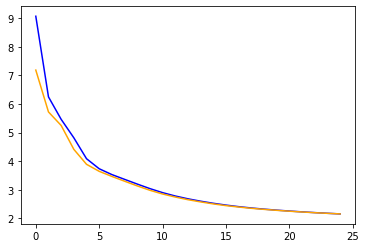

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

# Experiment with activation functions

In [ ]:
# Using activation='tanh'
model = Sequential()
model.add(Dense(16,input_dim=11, activation = 'tanh'))
model.add(Dense(8,activation='tanh'))
model.add(Dense(1,activation='linear'))

In [ ]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_data=(X_train,y_train),epochs=25,batch_size=128)

Epoch 1/25
754/754 [==============================] - 3s 4ms/step - loss: 6.3899 - mean_squared_error: 132.6289 - mean_absolute_error: 6.3899 - mean_absolute_percentage_error: 44.9389 - val_loss: 4.2981 - val_mean_squared_error: 88.6927 - val_mean_absolute_error: 4.2981 - val_mean_absolute_percentage_error: 26.5430
Epoch 2/25
754/754 [==============================] - 3s 4ms/step - loss: 3.8736 - mean_squared_error: 78.0364 - mean_absolute_error: 3.8736 - mean_absolute_percentage_error: 24.0792 - val_loss: 3.5571 - val_mean_squared_error: 70.2289 - val_mean_absolute_error: 3.5571 - val_mean_absolute_percentage_error: 22.4369
Epoch 3/25
754/754 [==============================] - 3s 4ms/step - loss: 3.3119 - mean_squared_error: 63.0239 - mean_absolute_error: 3.3119 - mean_absolute_percentage_error: 21.1988 - val_loss: 3.1408 - val_mean_squared_error: 58.0686 - val_mean_absolute_error: 3.1408 - val_mean_absolute_percentage_error: 20.5799
Epoch 4/25
754/754 [==============================]

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                192       
                                                                 
 dense_16 (Dense)            (None, 8)                 136       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


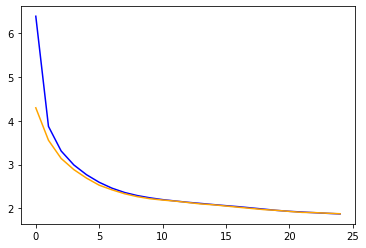

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

In [ ]:
# Using activation='relu'
model = Sequential()
model.add(Dense(16,input_dim=11, activation = 'relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='linear'))

In [ ]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_data=(X_train,y_train),epochs=25,batch_size=128)

Epoch 1/25
754/754 [==============================] - 3s 4ms/step - loss: 5.4579 - mean_squared_error: 94.6503 - mean_absolute_error: 5.4579 - mean_absolute_percentage_error: 47.6440 - val_loss: 2.5868 - val_mean_squared_error: 34.6772 - val_mean_absolute_error: 2.5868 - val_mean_absolute_percentage_error: 26.9412
Epoch 2/25
754/754 [==============================] - 3s 4ms/step - loss: 2.3803 - mean_squared_error: 33.5240 - mean_absolute_error: 2.3803 - mean_absolute_percentage_error: 23.5065 - val_loss: 2.2487 - val_mean_squared_error: 31.3446 - val_mean_absolute_error: 2.2487 - val_mean_absolute_percentage_error: 21.8239
Epoch 3/25
754/754 [==============================] - 3s 4ms/step - loss: 2.1530 - mean_squared_error: 30.4794 - mean_absolute_error: 2.1530 - mean_absolute_percentage_error: 20.2208 - val_loss: 2.0866 - val_mean_squared_error: 29.4126 - val_mean_absolute_error: 2.0866 - val_mean_absolute_percentage_error: 19.3802
Epoch 4/25
754/754 [==============================] 

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                192       
                                                                 
 dense_19 (Dense)            (None, 8)                 136       
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


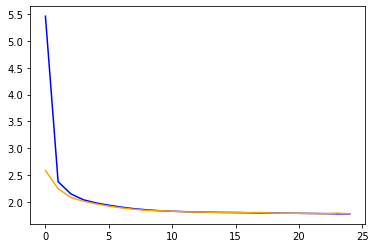

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

# Experiment with regularization techniques: Early stopping, Dropout rate

In [ ]:
# Early stopping
model = Sequential()
model.add(Dense(16,input_dim=11, activation = 'relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='linear'))

In [ ]:
from keras.callbacks import EarlyStopping
callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_data=(X_train,y_train),epochs=1000,batch_size=128,callbacks=callback)

Epoch 1/1000
754/754 [==============================] - 3s 4ms/step - loss: 4.8154 - mean_squared_error: 79.0783 - mean_absolute_error: 4.8154 - mean_absolute_percentage_error: 42.8368 - val_loss: 2.4879 - val_mean_squared_error: 30.8970 - val_mean_absolute_error: 2.4879 - val_mean_absolute_percentage_error: 25.7485
Epoch 2/1000
754/754 [==============================] - 3s 4ms/step - loss: 2.3229 - mean_squared_error: 30.0328 - mean_absolute_error: 2.3229 - mean_absolute_percentage_error: 22.8641 - val_loss: 2.2293 - val_mean_squared_error: 29.1945 - val_mean_absolute_error: 2.2293 - val_mean_absolute_percentage_error: 21.4690
Epoch 3/1000
754/754 [==============================] - 3s 4ms/step - loss: 2.1823 - mean_squared_error: 29.0828 - mean_absolute_error: 2.1823 - mean_absolute_percentage_error: 20.6747 - val_loss: 2.1588 - val_mean_squared_error: 28.7209 - val_mean_absolute_error: 2.1588 - val_mean_absolute_percentage_error: 20.2884
Epoch 4/1000
754/754 [========================

In [ ]:
# Dropout rate
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Dense(16,input_dim=11, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(8,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='linear'))

- There is no overfitting so dropout will not do any better.

In [ ]:
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])

In [ ]:
results=model.fit(train_scaled,labels,validation_split=0.2,epochs=25,batch_size=128)

Epoch 1/25
604/604 [==============================] - 3s 4ms/step - loss: 7.6890 - mean_squared_error: 130.0225 - mean_absolute_error: 7.6890 - mean_absolute_percentage_error: 67.5702 - val_loss: 4.0658 - val_mean_squared_error: 48.2634 - val_mean_absolute_error: 4.0658 - val_mean_absolute_percentage_error: 33.7218
Epoch 2/25
604/604 [==============================] - 2s 3ms/step - loss: 5.7122 - mean_squared_error: 89.3344 - mean_absolute_error: 5.7122 - mean_absolute_percentage_error: 51.3883 - val_loss: 3.5286 - val_mean_squared_error: 40.6616 - val_mean_absolute_error: 3.5286 - val_mean_absolute_percentage_error: 29.3667
Epoch 3/25
604/604 [==============================] - 2s 4ms/step - loss: 5.1958 - mean_squared_error: 80.4352 - mean_absolute_error: 5.1958 - mean_absolute_percentage_error: 45.6332 - val_loss: 3.3376 - val_mean_squared_error: 39.6238 - val_mean_absolute_error: 3.3376 - val_mean_absolute_percentage_error: 27.2832
Epoch 4/25
604/604 [==============================]

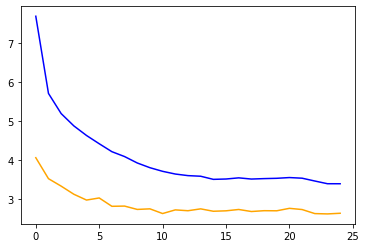

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

# Experiment with optimizers

In [ ]:
model = Sequential()
model.add(Dense(16,input_dim=11, activation = 'relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='linear'))

In [ ]:
model.compile(loss='mean_absolute_error',optimizer='SGD',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_split=0.2,epochs=10,batch_size=128)

Epoch 1/10
604/604 [==============================] - 2s 3ms/step - loss: 3.5219 - mean_squared_error: 52.8731 - mean_absolute_error: 3.5219 - mean_absolute_percentage_error: 32.1348 - val_loss: 2.1846 - val_mean_squared_error: 27.2183 - val_mean_absolute_error: 2.1846 - val_mean_absolute_percentage_error: 21.7849
Epoch 2/10
604/604 [==============================] - 2s 3ms/step - loss: 2.1469 - mean_squared_error: 29.4228 - mean_absolute_error: 2.1469 - mean_absolute_percentage_error: 19.6683 - val_loss: 2.1125 - val_mean_squared_error: 26.7202 - val_mean_absolute_error: 2.1125 - val_mean_absolute_percentage_error: 20.3727
Epoch 3/10
604/604 [==============================] - 2s 3ms/step - loss: 2.0777 - mean_squared_error: 28.7654 - mean_absolute_error: 2.0777 - mean_absolute_percentage_error: 18.8748 - val_loss: 2.0473 - val_mean_squared_error: 25.7731 - val_mean_absolute_error: 2.0473 - val_mean_absolute_percentage_error: 20.5561
Epoch 4/10
604/604 [==============================] 

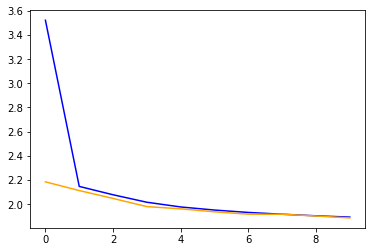

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

In [ ]:
# Adagrad
model.compile(loss='mean_absolute_error',optimizer='Adagrad',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_split=0.2,epochs=10,batch_size=128)

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

In [ ]:
# RMSprop
model.compile(loss='mean_absolute_error',optimizer='RMSprop',metrics=['MeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError'])
results=model.fit(train_scaled,labels,validation_split=0.2,epochs=10,batch_size=128)

In [ ]:
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color = "#FFA500")

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,6
plt.plot(results.history['loss'],color = "#0000FF")
plt.plot(results.history['val_loss'],color ="#FFA500")
plt.legend()